In [1]:
import geopandas as gpd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import src
from run import filepath_inspections_cleaned, filepath_portcalls_cleaned, filepath_inspections_processed, filepath_portcalls_processed

inspections_cleaned = pd.read_pickle(filepath_inspections_cleaned)
portcalls_cleaned = pd.read_pickle(filepath_portcalls_cleaned)

inspections_processed = pd.read_pickle(filepath_inspections_processed)
portcalls_processed = pd.read_pickle(filepath_portcalls_processed)

# Preprocessing

## Missing risk
Some port calls miss an entry for the risk. 
Virtually all portcalls with a missing risk, have priority PI.
This priority is commonly associated with risk 1 and hence we categorize all these portcalls with risk 1.

In [2]:
portcalls_cleaned['risk'].isna().value_counts()

False    4922948
True      469750
Name: risk, dtype: int64

In [3]:
portcalls_cleaned.groupby(['priority'])['risk'].value_counts(normalize=True).sort_index()

priority     risk
No priority  0       0.236094
             1       0.737607
             2       0.026299
PI           0       0.004840
             1       0.948633
             2       0.046527
PII          0       0.146761
             1       0.796463
             2       0.056777
Name: risk, dtype: float64

In [4]:
portcalls_cleaned.loc[lambda x: x['risk'].isna()]['priority'].value_counts()

PI             378194
No priority        64
PII                 1
Name: priority, dtype: int64

In [5]:
portcalls_cleaned.fillna({'risk': 1}, inplace=True)

## Filter on dates

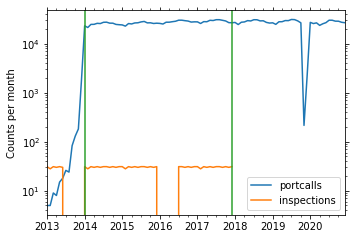

In [6]:
fig, ax = plt.subplots(figsize=(4.82,3.21), constrained_layout=True)
portcalls_cleaned['arrival'].value_counts().resample('M').size().plot(label='portcalls', ax=ax)
inspections_cleaned['DateOfFirstVisit'].value_counts().resample('M').size().plot(label='inspections', ax=ax)

ax.axvline(src.START_DATE, 0, 10_000, color='C2')
ax.axvline(src.END_DATE, 0, 10_000, color='C2')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_ylabel('Counts per month')
ax.set_yscale('log')
ax.legend(loc='lower right')

## Age of ship

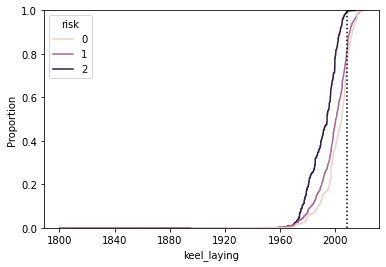

In [7]:
fig, ax = plt.subplots()

sns.ecdfplot(data=portcalls_cleaned.astype({'risk': 'int'}), x='keel_laying', hue='risk', ax=ax)
ax.axvline(portcalls_cleaned['keel_laying'].max() - pd.DateOffset(years=12), c='black', ls=':')

## Type of ship

In [8]:
df = portcalls_cleaned[['type', 'type_high_risk']].drop_duplicates()
high_risk = df.loc[lambda x: x['type_high_risk'], "type"].values
low_risk = df.loc[lambda x: ~x['type_high_risk'], "type"].values
print(f"High risk types: {high_risk}")
print(f"Low risk types: {low_risk}")

High risk types: ['Ro-Ro passenger ship' 'Oil tanker' 'Chemical tanker'
 'High speed passenger craft' 'Bulk carrier' 'Passenger ship' 'NLS tanker'
 'Gas carrier' 'Oil tanker/Chemical tanker ' 'Combination carrier'
 'Oil tanker/NLS tanker ' 'Gas Carrier/NLS tanker']
Low risk types: ['Ro-Ro cargo' 'Container' 'General cargo/multipurpose' 'Tug'
 'Other special activities' 'Dredger' nan 'Offshore supply'
 'Refrigerated cargo' 'Heavy load' 'Warship and naval auxiliary'
 'MODU & FPSO' 'Fishing vessel' 'Pleasure yacht not engaged in trade'
 'Commercial yacht' 'Fish factory' 'Special purpose ship'
 'Government ship used for non-commercial purpose' 'High speed cargo'
 'Livestock carrier' 'Wooden ship of a primitive build']


## Flag

In [9]:
cols = ['flag_in_pmou', 'flag_code']
df = portcalls_cleaned[cols].drop_duplicates().sort_values(cols)
flags_in_pmou = df.loc[lambda x: x['flag_in_pmou'], 'flag_code'].values
flags_not_in_pmou = df.loc[lambda x: ~x['flag_in_pmou'], 'flag_code'].values
print(f"Flag in pmou: {flags_in_pmou}")
print(f"Flag not in pmou: {flags_not_in_pmou}")

Flag in pmou: ['BE' 'BG' 'CA' 'CY' 'DE' 'DK' 'EE' 'ES' 'FI' 'FR' 'GB' 'GR' 'HR' 'IE'
 'IS' 'IT' 'LT' 'LV' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RU' 'SE' 'SI']
Flag in pmou: ['AE' 'AF' 'AG' 'AL' 'AO' 'AR' 'AT' 'AU' 'AZ' 'BB' 'BD' 'BH' 'BM' 'BO'
 'BR' 'BS' 'BZ' 'CD' 'CG' 'CH' 'CK' 'CL' 'CM' 'CN' 'CO' 'CU' 'CV' 'CW'
 'DJ' 'DM' 'DZ' 'EC' 'EG' 'ET' 'FK' 'FM' 'FO' 'GA' 'GE' 'GG' 'GH' 'GI'
 'GN' 'GQ' 'GT' 'GW' 'GY' 'HK' 'HN' 'ID' 'IL' 'IM' 'IN' 'IQ' 'IR' 'JE'
 'JM' 'JO' 'JP' 'KE' 'KH' 'KI' 'KM' 'KN' 'KR' 'KW' 'KY' 'KZ' 'LB' 'LK'
 'LR' 'LU' 'LY' 'MA' 'MC' 'MD' 'ME' 'MH' 'MN' 'MO' 'MR' 'MU' 'MX' 'MY'
 'MZ' 'NG' 'NOT_MENTIONED' 'NU' 'NZ' 'OM' 'PA' 'PE' 'PH' 'PK' 'PW' 'QA'
 'REGISTER_WITHDRAWN' 'SA' 'SC' 'SG' 'SL' 'SN' 'SR' 'ST' 'SV' 'SY' 'TG'
 'TH' 'TN' 'TR' 'TT' 'TV' 'TW' 'TZ' 'UA' 'US' 'UY' 'VC' 'VE' 'VG' 'VI'
 'VN' 'VU' 'WS' 'ZA' nan]


In [10]:
portcalls_cleaned['flag_in_pmou'].value_counts(normalize=True)

True     0.709766
False    0.290234
Name: flag_in_pmou, dtype: float64

In [11]:
portcalls_cleaned['flag'].value_counts(normalize=True)

0    0.968616
1    0.017837
2    0.013547
Name: flag, dtype: Float64

In [12]:
portcalls_cleaned['risk'].value_counts().sort_index()

0     946712
1    4288785
2     157201
Name: risk, dtype: Int64

In [13]:
display(
    portcalls_cleaned[['flag_in_pmou', 'risk']]
    .value_counts()
    .sort_index()
    .reset_index()
    .pivot(['flag_in_pmou'], ['risk'], 0)
    .apply(lambda x: x/ x.sum(), axis='columns')
)

display(
    portcalls_cleaned[['flag_in_pmou', 'risk']]
    .value_counts()
    .sort_index()
    .reset_index()
    .pivot(['flag_in_pmou'], ['risk'], 0)
)

risk,0,1,2
flag_in_pmou,,,
False,0.146483,0.812605,0.040911
True,0.187442,0.788216,0.024342


risk,0,1,2
flag_in_pmou,,,
False,229268,1271847,64032
True,717444,3016938,93169


## Country of port

<AxesSubplot:>

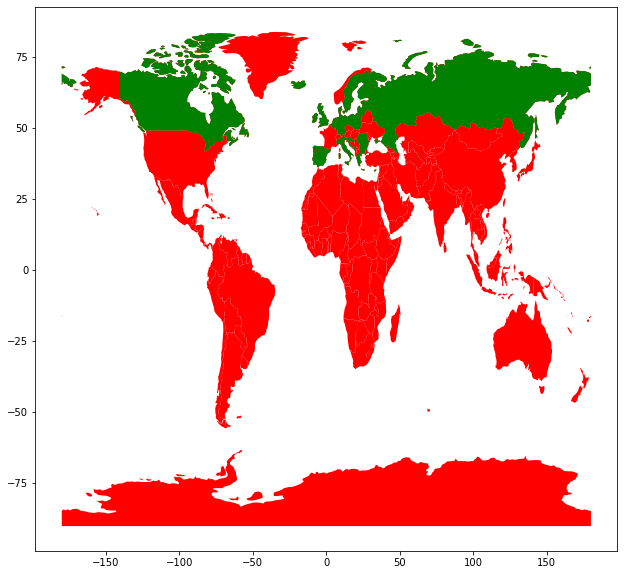

In [14]:
iso3166alpha2 = portcalls_processed['port'].str[:2].unique()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
url = "https://gist.github.com/tadast/8827699/raw/f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv"
iso3166 = pd.read_csv(url).apply(lambda x: x.str.replace('"', "").str.strip())

mask = iso3166.set_index('Alpha-2 code')['Alpha-3 code'].to_dict()
iso3166alpha3 = [mask[country] for country in portcalls_cleaned['port'].str[:2].unique()]
fig, ax = plt.subplots(figsize=(15,10))
world.plot(ax=ax, color='red')
world.loc[lambda x: x.iso_a3.isin(iso3166alpha3)].plot(color='green', ax=ax)

## Sent At

In [15]:
portcalls_cleaned['Sent.At'].agg(['min', 'max'])

min    2011-10-05 13:37:58
max    2021-04-27 12:46:39
Name: Sent.At, dtype: object

# Stats

In [16]:
first_inspection = inspections_processed.groupby('IMO')['DateOfFirstVisit'].first().to_dict()

result = dict()
ship_not_inspected = list()

for ship, group in tqdm(portcalls_processed.groupby('ship')):
    if ship in first_inspection:
        result[ship] = (group['arrival'] < first_inspection[ship]).sum()
    else:
        ship_not_inspected.append(ship)
result = pd.Series(result)

{
    'number of portcalls': len(portcalls_processed),
    'number of ships': portcalls_processed.ship.nunique(),
    'number of ships without any portcalls': len(set(inspections_processed['IMO'].unique()) - set(portcalls_processed['ship'].unique())),
    'number of ships not inspected': len(ship_not_inspected),
    'fraction of ships not inspected': len(ship_not_inspected) / portcalls_processed.ship.nunique(),
}

  0%|          | 0/28416 [00:00<?, ?it/s]

{'number of portcalls': 3097752,
 'number of ships': 28416,
 'number of ships without any portcalls': 1751,
 'number of ships not inspected': 5976,
 'fraction of ships not inspected': 0.21030405405405406}

## Number of portcalls before inspection

Text(0.5, 0, 'Number of portcalls before inspection')

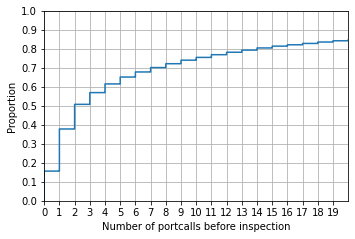

In [17]:
fig, ax = plt.subplots(figsize=(4.82,3.21), constrained_layout=True)
sns.ecdfplot(list(result.values), stat='proportion', ax=ax)
ax.set_xlim(0, 20)
ax.set_xticks(range(20))
ax.set_yticks(np.linspace(0, 1, 11))
ax.grid()
ax.set_xlabel('Number of portcalls before inspection')

## Some ships with many portcalls

In [18]:
pd.Series(result).sort_values().tail(10)

9587855     1414
9007128     1429
9135262     1494
7351082     1527
8518546     1822
9151539     2071
8916126     2202
9170183     4679
9237644     6425
9151541    13474
dtype: int64

## Ship flag history

In [19]:
portcalls = (
    portcalls_cleaned
    .loc[lambda x: src.START_DATE <= x['arrival']]
    .loc[lambda x: x['arrival'] <= src.END_DATE]
    .loc[lambda x: x['ship'].duplicated(keep=False)]
    .dropna(subset=['flag'])
    .astype({'flag': 'int'})
)

result = list()
result2 = list()
number_of_changes_list = list()
for ship, group in portcalls.groupby('ship')['flag']:
    number_of_changes = (group.values != group.shift(1).values).sum() - 1
    number_of_changes_list.append(number_of_changes)
    if number_of_changes == 0:
        result.append(group.iloc[0])
    elif number_of_changes == 1:
        result2.append((group.iloc[0], group.iloc[-1]))
result = pd.Series(result)

total = len(number_of_changes_list)
print(f"Total number of ships: {total}")
print()
not_changing = (np.array(number_of_changes_list) == 0).sum()
changing = (np.array(number_of_changes_list) > 0).sum()
print(f"Total number of ships not changing flag: {not_changing} ({not_changing/total:.1%})")
print(f"Total number of ships changing flag: {changing} ({changing/total:.1%})")
print()
print(f"Total changes of flag: {np.bincount(number_of_changes_list)}")
np.set_printoptions(suppress=True)
message = 100*np.bincount(number_of_changes_list) / len(number_of_changes_list)
print(f"Total changes of flag (relative): {message}")
print()
message = "From the ships that don't change flag, number of white/grey/black ships"
print(f"{message}: {np.bincount(result)}")
print()
print("Type of changes:")
from collections import Counter
print(Counter(result2))
print()
more_worse_flag = np.bincount([a>b for a, b in result2]) / changing
print(f"Fraction of ships moving to better/worse flag: {more_worse_flag}")

Total number of ships: 28416

Total number of ships not changing flag: 27647 (97.3%)
Total number of ships changing flag: 769 (2.7%)

Total changes of flag: [27647   722    44     2     1]
Total changes of flag (relative): [97.29377815  2.54082207  0.15484234  0.00703829  0.00351914]

From the ships that don't change flag, number of white/grey/black ships: [26300   672   675]

Type of changes:
Counter({(0, 2): 271, (1, 0): 195, (0, 1): 132, (2, 0): 85, (1, 2): 29, (2, 1): 10})

Fraction of ships moving to better/worse flag: [0.56176853 0.37711313]
